Adjusting VGG architecture for use with CIFAR-10 dataset. Training VGG-16 from scratch.

Check the GPU assigned:

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed May  5 12:50:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# install  PyTorch
!pip install torch torchvision

In [3]:
import torch
torch.__version__

'1.8.1+cu101'

In [4]:
from torchvision.datasets import CIFAR10
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import time as t
from torch import nn, optim
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader

import torch.nn as nn
#from .utils import load_state_dict_from_url
from typing import Union, List, Dict, Any, cast

## Define the model
https://pytorch.org/vision/stable/_modules/torchvision/models/vgg.html

VGG is automatically set up for ImageNet, which has 1000 classes, with CIFAR-10, we only have 10.

In [5]:
__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
    'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
    'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
}

In [6]:
class VGG(nn.Module):

    def __init__(
        self,
        features: nn.Module,
        num_classes: int = 10,
        init_weights: bool = True
    ) -> None:
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg: List[Union[str, int]], batch_norm: bool = False) -> nn.Sequential:
    layers: List[nn.Module] = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            v = cast(int, v)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [7]:
cfgs: Dict[str, List[Union[str, int]]] = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [8]:
def _vgg(arch: str, cfg: str, batch_norm: bool, pretrained: bool, progress: bool, **kwargs: Any) -> VGG:
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm), **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

In [9]:
def vgg11(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> VGG:
    r"""VGG 11-layer model (configuration "A") from
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`._

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg11', 'A', False, pretrained, progress, **kwargs)

In [10]:
def vgg11_bn(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> VGG:
    r"""VGG 11-layer model (configuration "A") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`._

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg11_bn', 'A', True, pretrained, progress, **kwargs)

In [11]:
def vgg13(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> VGG:
    r"""VGG 13-layer model (configuration "B")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`._

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg13', 'B', False, pretrained, progress, **kwargs)

In [12]:
def vgg13_bn(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> VGG:
    r"""VGG 13-layer model (configuration "B") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`._

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg13_bn', 'B', True, pretrained, progress, **kwargs)

In [13]:
def vgg16(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> VGG:
    r"""VGG 16-layer model (configuration "D")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`._

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg16', 'D', False, pretrained, progress, **kwargs)

In [14]:
def vgg16_bn(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> VGG:
    r"""VGG 16-layer model (configuration "D") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`._

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg16_bn', 'D', True, pretrained, progress, **kwargs)

In [15]:
# select the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# define the model
model = vgg16(False,True).to(device)

In [16]:
# view the details of the model
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Set variables

In [17]:
epochs = 50
batch_size = 16
learning_rate = 0.0001

## Download data
Loading CIFAR-10 data. Images need to be rescaled and numbers normalised.

In [18]:
def get_data_loaders(train_batch_size, val_batch_size):
    #cifar10 = CIFAR10(download=True, train=True, root=".").train_data.float()

    data_transform = Compose([ Resize((224, 224)),ToTensor(),  Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])

    train_loader = DataLoader(CIFAR10(download=True, root=".", transform=data_transform, train=True),
                              batch_size=train_batch_size, shuffle=True)

    val_loader = DataLoader(CIFAR10(download=False, root=".", transform=data_transform, train=False),
                            batch_size=val_batch_size, shuffle=True)
    return train_loader, val_loader

In [19]:
# load the data to variables
train_loader, val_loader = get_data_loaders(batch_size, batch_size)


Extracting ./cifar-10-python.tar.gz to .


## Run the model

In [20]:
# helper function
def calculate_metric(metric_fn, true_y, pred_y):
  # multi class problems need to have averaging methods
  if "average" in inspect.getfullargspec(metric_fn).args:
    return metric_fn(true_y, pred_y, average="macro")
  else:
    return metric_fn(true_y, pred_y)
    
def print_scores(p, r, f1, a, batch_size):
  # a utility printing mfunction
  for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
    print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

In [21]:
# import datetime to include in submission
from datetime import datetime

In [22]:
# empty memory
torch.cuda.empty_cache()

In [23]:
start_ts = t.time()
now_start = datetime.now()
print(f"Starting training with {epochs} epochs on {now_start.strftime('%d/%m/%Y %H:%M:%S')}")


losses_train = []
losses_val = []
accuracies = []
times = []
# loss function, corss entropy works well for multi-class problems
loss_function = nn.CrossEntropyLoss()
# an optimiser
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.Adadelta(model.parameters())

batches = len(train_loader)
val_batches = len(val_loader)

# training loop + eval loop
for epoch in range(epochs):
    start_epoch = t.time()
    total_loss = 0
    # progress bar
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)

    # ----------------- TRAINING  -------------------- 
    # set model to training
    model.train()
    
    for i, data in progress:
        X, y = data[0].to(device), data[1].to(device)
        
        # training step for single batch
        model.zero_grad()
        outputs = model(X)
        loss = loss_function(outputs, y)

        loss.backward()
        optimizer.step()

        # getting training quality data
        current_loss = loss.item()
        total_loss += current_loss

        # updating progress bar
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))

    # releasing unnecessary memory in GPU 
    if torch.cuda.is_available():
      torch.cuda.empty_cache()
    
    # ----------------- VALIDATION  -----------------
    val_losses = 0
    precision, recall, f1, accuracy = [], [], [], []
    
    # set model to evaluating (testing)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            X, y = data[0].to(device), data[1].to(device)
            outputs = model(X) # this gets the prediction from the network
            val_losses += loss_function(outputs, y)

            predicted_classes = torch.max(outputs, 1)[1] # get class from networks prediction
            
            # calculate P/R/F1/A metrics for batch
            for acc, metric in zip((precision, recall, f1, accuracy), 
                                   (precision_score, recall_score, f1_score, accuracy_score)):
                acc.append(
                    calculate_metric(metric, y.cpu(), predicted_classes.cpu())
                )
        
    print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
    print_scores(precision, recall, f1, accuracy, val_batches)
    losses_train.append(total_loss/batches) # for plotting learning curve
    losses_val.append(float((val_losses/val_batches).cpu()))
    times.append((t.time() - start_epoch)/60)
    accuracies.append(sum(accuracy)/len(accuracy))
print("Training losses:")
print(losses_train)
print("Validation losses:")
print(losses_val)
print("Accuracies:")
print(accuracies)
print()
now_end = datetime.now()
print(f"Training finished at {now_end.strftime('%d/%m/%Y %H:%M:%S')}")
print(f"Training time: {(t.time()-start_ts)/60} minutes")

Starting training with 50 epochs on 05/05/2021 12:51:04


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50, training loss: 1.4981288440608977, validation loss: 1.047541618347168
	     precision: 0.5609
	        recall: 0.5725
	            F1: 0.5347
	      accuracy: 0.6284



Epoch 2/50, training loss: 0.8434391725206375, validation loss: 0.8514952659606934
	     precision: 0.6478
	        recall: 0.6525
	            F1: 0.6217
	      accuracy: 0.7100



Epoch 3/50, training loss: 0.5752810243439674, validation loss: 0.6118823289871216
	     precision: 0.7420
	        recall: 0.7430
	            F1: 0.7196
	      accuracy: 0.7903



Epoch 4/50, training loss: 0.3692056632524729, validation loss: 0.5984736084938049
	     precision: 0.7579
	        recall: 0.7585
	            F1: 0.7364
	      accuracy: 0.8032



Epoch 5/50, training loss: 0.20872360315483063, validation loss: 0.6673332452774048
	     precision: 0.7601
	        recall: 0.7619
	            F1: 0.7395
	      accuracy: 0.8039



Epoch 6/50, training loss: 0.1326783822731767, validation loss: 0.8730427622795105
	     precision: 0.7555
	        recall: 0.7580
	            F1: 0.7353
	      accuracy: 0.8026



Epoch 7/50, training loss: 0.09744845461709425, validation loss: 0.9087135791778564
	     precision: 0.7644
	        recall: 0.7689
	            F1: 0.7454
	      accuracy: 0.8103



Epoch 8/50, training loss: 0.08280542901700218, validation loss: 0.925818145275116
	     precision: 0.7530
	        recall: 0.7542
	            F1: 0.7317
	      accuracy: 0.8028



Epoch 9/50, training loss: 0.07183775448564149, validation loss: 0.8550876975059509
	     precision: 0.7564
	        recall: 0.7584
	            F1: 0.7351
	      accuracy: 0.8017



Epoch 10/50, training loss: 0.06532768272124943, validation loss: 0.8625869750976562
	     precision: 0.7616
	        recall: 0.7623
	            F1: 0.7404
	      accuracy: 0.8072



Epoch 11/50, training loss: 0.056293121201218016, validation loss: 0.994473397731781
	     precision: 0.7457
	        recall: 0.7480
	            F1: 0.7254
	      accuracy: 0.7995



Epoch 12/50, training loss: 0.05308692975722151, validation loss: 0.9992046356201172
	     precision: 0.7568
	        recall: 0.7562
	            F1: 0.7341
	      accuracy: 0.7977



Epoch 13/50, training loss: 0.049689014288615635, validation loss: 0.9420008659362793
	     precision: 0.7565
	        recall: 0.7627
	            F1: 0.7389
	      accuracy: 0.8080



Epoch 14/50, training loss: 0.046080209860185135, validation loss: 1.0292227268218994
	     precision: 0.7577
	        recall: 0.7578
	            F1: 0.7356
	      accuracy: 0.7996



Epoch 15/50, training loss: 0.041507425305756476, validation loss: 1.1086790561676025
	     precision: 0.7524
	        recall: 0.7498
	            F1: 0.7288
	      accuracy: 0.7968



Epoch 16/50, training loss: 0.03961214348415489, validation loss: 0.9974934458732605
	     precision: 0.7568
	        recall: 0.7576
	            F1: 0.7369
	      accuracy: 0.8077



Epoch 17/50, training loss: 0.038667746918582525, validation loss: 0.9913379549980164
	     precision: 0.7597
	        recall: 0.7583
	            F1: 0.7382
	      accuracy: 0.8073



Epoch 18/50, training loss: 0.03576477958978465, validation loss: 1.2173538208007812
	     precision: 0.7467
	        recall: 0.7508
	            F1: 0.7269
	      accuracy: 0.7954



Epoch 19/50, training loss: 0.03425091086640964, validation loss: 1.124079704284668
	     precision: 0.7519
	        recall: 0.7509
	            F1: 0.7304
	      accuracy: 0.8012



Epoch 20/50, training loss: 0.03231436777616587, validation loss: 0.9945932626724243
	     precision: 0.7635
	        recall: 0.7620
	            F1: 0.7418
	      accuracy: 0.8074



Epoch 21/50, training loss: 0.03370641881875916, validation loss: 1.0976160764694214
	     precision: 0.7701
	        recall: 0.7693
	            F1: 0.7488
	      accuracy: 0.8117



Epoch 22/50, training loss: 0.03195571218297041, validation loss: 1.0776411294937134
	     precision: 0.7500
	        recall: 0.7512
	            F1: 0.7278
	      accuracy: 0.7997



Epoch 23/50, training loss: 0.03058818882850636, validation loss: 0.9837071895599365
	     precision: 0.7565
	        recall: 0.7578
	            F1: 0.7363
	      accuracy: 0.8069



Epoch 24/50, training loss: 0.026745797468640694, validation loss: 1.2469300031661987
	     precision: 0.7562
	        recall: 0.7609
	            F1: 0.7369
	      accuracy: 0.8019



Epoch 25/50, training loss: 0.028908079902345268, validation loss: 1.2660071849822998
	     precision: 0.7562
	        recall: 0.7561
	            F1: 0.7343
	      accuracy: 0.8001



Epoch 26/50, training loss: 0.02936888402002499, validation loss: 1.1433964967727661
	     precision: 0.7542
	        recall: 0.7551
	            F1: 0.7335
	      accuracy: 0.8064



Epoch 27/50, training loss: 0.02470836916513751, validation loss: 1.2263551950454712
	     precision: 0.7648
	        recall: 0.7692
	            F1: 0.7456
	      accuracy: 0.8104



Epoch 28/50, training loss: 0.02536905558814976, validation loss: 1.0638097524642944
	     precision: 0.7609
	        recall: 0.7626
	            F1: 0.7416
	      accuracy: 0.8086



Epoch 29/50, training loss: 0.02418358108028182, validation loss: 1.3918267488479614
	     precision: 0.7532
	        recall: 0.7568
	            F1: 0.7332
	      accuracy: 0.8027



Epoch 30/50, training loss: 0.02433986669828229, validation loss: 1.2985509634017944
	     precision: 0.7625
	        recall: 0.7626
	            F1: 0.7412
	      accuracy: 0.8080



Epoch 31/50, training loss: 0.02361230671824256, validation loss: 1.2391507625579834
	     precision: 0.7687
	        recall: 0.7668
	            F1: 0.7460
	      accuracy: 0.8090



Epoch 32/50, training loss: 0.02238897832691718, validation loss: 1.3752350807189941
	     precision: 0.7612
	        recall: 0.7601
	            F1: 0.7391
	      accuracy: 0.8052



Epoch 33/50, training loss: 0.023823708193687024, validation loss: 1.2759507894515991
	     precision: 0.7683
	        recall: 0.7681
	            F1: 0.7472
	      accuracy: 0.8113



Epoch 34/50, training loss: 0.022611085934349844, validation loss: 1.2573707103729248
	     precision: 0.7678
	        recall: 0.7654
	            F1: 0.7452
	      accuracy: 0.8102



Epoch 35/50, training loss: 0.022605596803738564, validation loss: 1.387752652168274
	     precision: 0.7659
	        recall: 0.7652
	            F1: 0.7444
	      accuracy: 0.8108



Epoch 36/50, training loss: 0.023156330634302294, validation loss: 1.2388619184494019
	     precision: 0.7677
	        recall: 0.7666
	            F1: 0.7463
	      accuracy: 0.8146



Epoch 37/50, training loss: 0.02235652862936889, validation loss: 1.2405707836151123
	     precision: 0.7677
	        recall: 0.7729
	            F1: 0.7492
	      accuracy: 0.8122



Epoch 38/50, training loss: 0.022000826070570228, validation loss: 1.408958911895752
	     precision: 0.7586
	        recall: 0.7579
	            F1: 0.7360
	      accuracy: 0.8069



Epoch 39/50, training loss: 0.020370715647971493, validation loss: 1.456588864326477
	     precision: 0.7558
	        recall: 0.7585
	            F1: 0.7352
	      accuracy: 0.8053



Epoch 40/50, training loss: 0.02008809809530432, validation loss: 1.632420301437378
	     precision: 0.7622
	        recall: 0.7613
	            F1: 0.7412
	      accuracy: 0.8101



Epoch 41/50, training loss: 0.020588058882726863, validation loss: 1.4524551630020142
	     precision: 0.7499
	        recall: 0.7546
	            F1: 0.7318
	      accuracy: 0.8071



Epoch 42/50, training loss: 0.02003077453121208, validation loss: 1.429731845855713
	     precision: 0.7616
	        recall: 0.7612
	            F1: 0.7395
	      accuracy: 0.8047



Epoch 43/50, training loss: 0.02137494754056559, validation loss: 1.2836494445800781
	     precision: 0.7512
	        recall: 0.7562
	            F1: 0.7324
	      accuracy: 0.8040



Epoch 44/50, training loss: 0.020832507194234882, validation loss: 1.347071886062622
	     precision: 0.7676
	        recall: 0.7669
	            F1: 0.7475
	      accuracy: 0.8130



Epoch 45/50, training loss: 0.020453434273067395, validation loss: 1.4290333986282349
	     precision: 0.7635
	        recall: 0.7639
	            F1: 0.7427
	      accuracy: 0.8101



Epoch 46/50, training loss: 0.021382492968601337, validation loss: 1.3158186674118042
	     precision: 0.7635
	        recall: 0.7642
	            F1: 0.7433
	      accuracy: 0.8089



Epoch 47/50, training loss: 0.01962433757258429, validation loss: 1.3373318910598755
	     precision: 0.7638
	        recall: 0.7629
	            F1: 0.7427
	      accuracy: 0.8108



Epoch 48/50, training loss: 0.01859269944226012, validation loss: 1.7136101722717285
	     precision: 0.7566
	        recall: 0.7549
	            F1: 0.7334
	      accuracy: 0.8009



Epoch 49/50, training loss: 0.019698973164245744, validation loss: 1.5724492073059082
	     precision: 0.7592
	        recall: 0.7634
	            F1: 0.7371
	      accuracy: 0.8000



Epoch 50/50, training loss: 0.019273620956790877, validation loss: 1.580174207687378
	     precision: 0.7591
	        recall: 0.7620
	            F1: 0.7397
	      accuracy: 0.8073
Training losses:
[1.4981288440608977, 0.8434391725206375, 0.5752810243439674, 0.3692056632524729, 0.20872360315483063, 0.1326783822731767, 0.09744845461709425, 0.08280542901700218, 0.07183775448564149, 0.06532768272124943, 0.056293121201218016, 0.05308692975722151, 0.049689014288615635, 0.046080209860185135, 0.041507425305756476, 0.03961214348415489, 0.038667746918582525, 0.03576477958978465, 0.03425091086640964, 0.03231436777616587, 0.03370641881875916, 0.03195571218297041, 0.03058818882850636, 0.026745797468640694, 0.028908079902345268, 0.02936888402002499, 0.02470836916513751, 0.02536905558814976, 0.02418358108028182, 0.02433986669828229, 0.02361230671824256, 0.02238897832691718, 0.023823708193687024, 0.022611085934349844, 0.022605596803738564, 0.023156330634302294, 0.02235652862936889, 0.022000826070570

Plot the training and validation loss

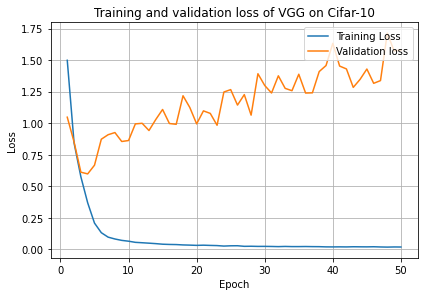

In [24]:
import matplotlib.pyplot as plt

x = range(1,epochs+1)

plt.plot(x, losses_train, label = "Training Loss")
plt.plot(x, losses_val, label = "Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=1)
plt.grid(True)
plt.tight_layout()
plt.title('Training and validation loss of VGG on Cifar-10')
plt.savefig('Cifar10_VGG_Train.png')
plt.show()

Plot accuracy

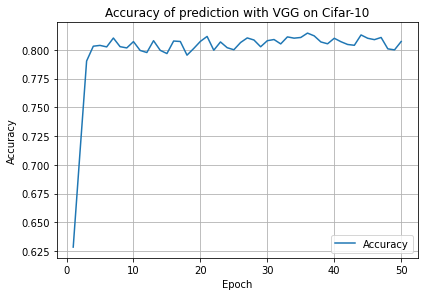

In [25]:
import matplotlib.pyplot as plt

x = range(1,epochs+1)

plt.plot(x, accuracies, label = "Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=4)
plt.grid(True)
plt.tight_layout()
plt.title('Accuracy of prediction with VGG on Cifar-10')
plt.savefig('Cifar10_VGG_Accuracy.png')
plt.show()

Export values for loss and accuracy to a CSV file for later plotting/evaluation.

In [26]:
import pandas as pd
data = {'Data': 'Cifar-10', 'Model': 'VGG', 'Epoch': x, 'Training loss': losses_train,
     'Validation loss': losses_val, 'Accuracy': accuracies, 'Time_per_epoch': times}
df = pd.DataFrame(data)
df.to_csv('Cifar10_VGG.csv', index=False)

Save the model

In [28]:
# save the model
torch.save(model,'VGG.h5')